# Simple inverse problem

Almost according to the mixture density network paper (Bishop, 1994).

In [1]:
from matplotlib import pyplot as plt

from ada import *

In [2]:
LEVELS = 64
STEPS = 1000

In [3]:
(trainset, testset), (X_scaler, y_scaler) = get_dataset("inverse", 50, False, False)
x_train, y_train = trainset.tensors
x_test, y_test = testset.tensors
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([900, 1]),
 torch.Size([900, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

In [4]:
# large test set
_, x_test, y_test = get_inverse(n=10000, seed=12)
x_test, y_test = numpy2torch(x_test), numpy2torch(y_test)
testset = TensorDataset(x_test, y_test)

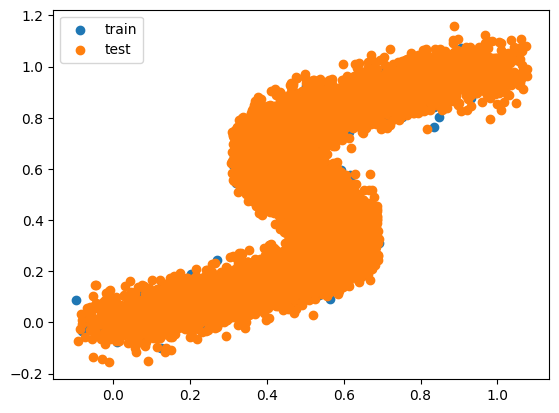

In [5]:
_, ax = plt.subplots()
ax.scatter(x_train, y_train, label="train")
ax.scatter(x_test, y_test, label="test")
ax.legend()

## NLL

In [6]:
hyperparams = {"neurons": 20}
hyperparams["loss"] = "nll"
model_nll = NeuralNetwork(x_train.shape[1], hyperparams)
model_nll.load("nll-1-1-4801")
y_nll = model_nll.predict(testset)

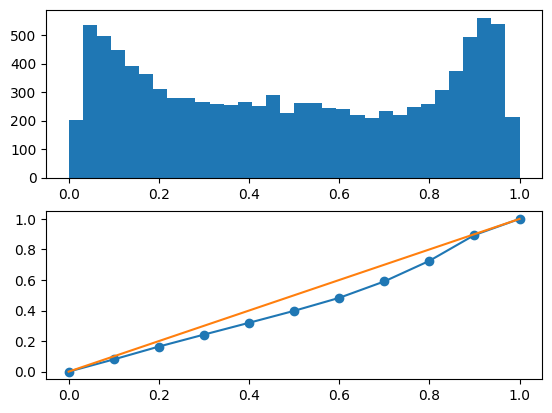

In [7]:
_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(normal_pit(*y_nll, y_test).squeeze(), bins=BINS)
calibration_curve(ax2, normal_reliability(*y_nll, y_test))

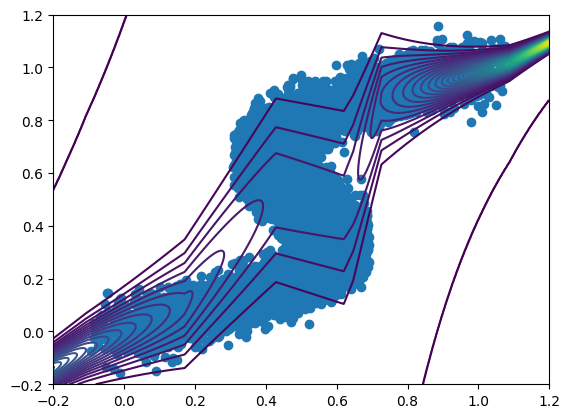

In [8]:
def plot_normal_density(ax, model):
    x = torch.linspace(-0.2, 1.2, steps=STEPS).unsqueeze(-1)
    y = torch.linspace(-0.2, 1.2, steps=STEPS).unsqueeze(-1)
    mean, variance = model.predict(TensorDataset(x))
    density = normal_pdf(y.unsqueeze(-1), mean.unsqueeze(0), variance.unsqueeze(0))
    ax.contour(x.squeeze(), y.squeeze(), density.squeeze(), levels=LEVELS)

_, ax = plt.subplots()
plot_normal_density(ax, model_nll)
ax.scatter(x_test, y_test)

## CRPS

In [9]:
hyperparams["loss"] = "crps"
model_crps = NeuralNetwork(x_train.shape[1], hyperparams)
model_crps.load("crps-1-1-2579")
y_crps = model_crps.predict(testset)

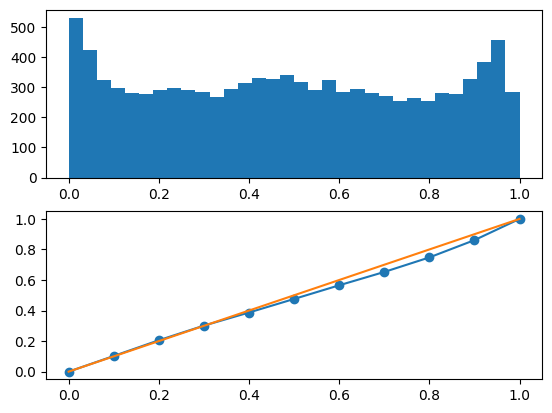

In [10]:
_, (ax1, ax2) = plt.subplots(nrows=2)
ax1.hist(normal_pit(*y_crps, y_test).squeeze(), bins=BINS)
calibration_curve(ax2, normal_reliability(*y_crps, y_test))

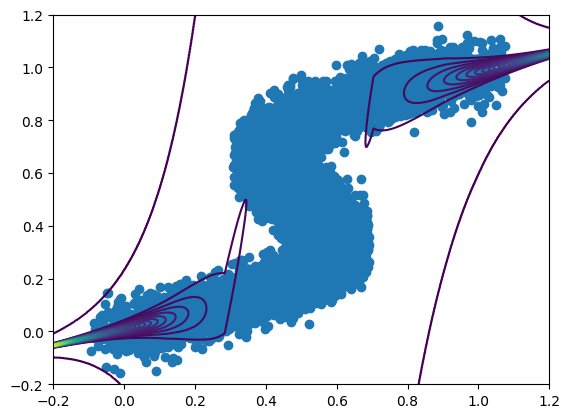

In [11]:
_, ax = plt.subplots()
plot_normal_density(ax, model_crps)
ax.scatter(x_test, y_test)

## MDN and NLL

(array([450., 448., 394., 355., 356., 298., 290., 300., 269., 294., 264.,
        285., 275., 263., 277., 260., 291., 260., 297., 327., 310., 322.,
        266., 286., 277., 238., 282., 357., 290., 316., 348., 455.]),
 array([7.18235606e-06, 3.12562026e-02, 6.25052229e-02, 9.37542468e-02,
        1.25003263e-01, 1.56252295e-01, 1.87501311e-01, 2.18750328e-01,
        2.49999344e-01, 2.81248361e-01, 3.12497407e-01, 3.43746424e-01,
        3.74995440e-01, 4.06244457e-01, 4.37493473e-01, 4.68742490e-01,
        4.99991506e-01, 5.31240523e-01, 5.62489569e-01, 5.93738556e-01,
        6.24987602e-01, 6.56236649e-01, 6.87485635e-01, 7.18734682e-01,
        7.49983668e-01, 7.81232715e-01, 8.12481761e-01, 8.43730748e-01,
        8.74979794e-01, 9.06228781e-01, 9.37477827e-01, 9.68726814e-01,
        9.99975860e-01]),
 <BarContainer object of 32 artists>)

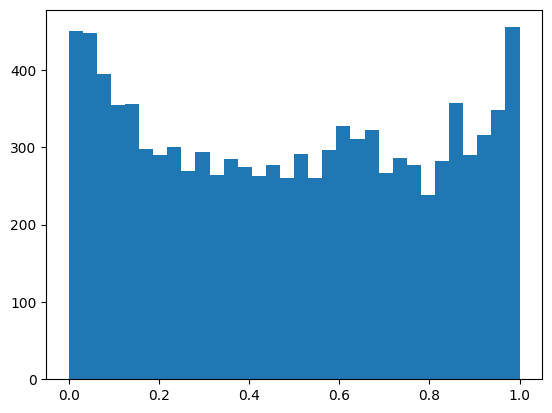

In [12]:
hyperparams["k"] = 3
hyperparams["loss"] = "nll"
mdn_nll = MixtureDensityNetwork(x_train.shape[1], hyperparams)
mdn_nll.load("nll-1-3-9807")
y_mdn_nll = mdn_nll.predict(testset)

_, ax = plt.subplots()
ax.hist(gmm_pit(*y_mdn_nll, y_test).squeeze(), bins=32)

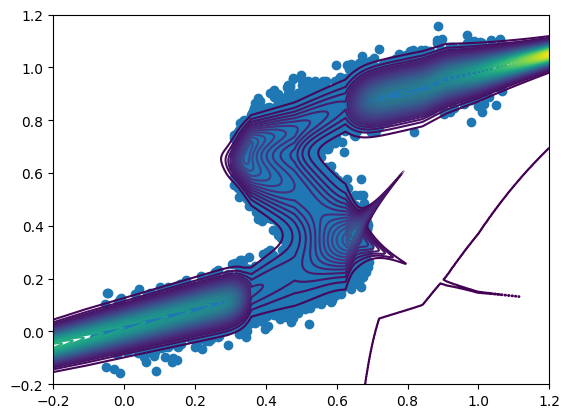

In [13]:
def plot_gmm_density(ax, model):
    x = torch.linspace(-0.2, 1.2, steps=STEPS).unsqueeze(-1)
    y = torch.linspace(-0.2, 1.2, steps=STEPS).unsqueeze(-1)
    coeffs, means, variances = model.predict(TensorDataset(x))
    density = gmm_pdf(y.unsqueeze(-1), coeffs.unsqueeze(0), means.unsqueeze(0), variances.unsqueeze(0))
    ax.contour(x.squeeze(), y.squeeze(), density.squeeze(), levels=LEVELS)

_, ax = plt.subplots()
plot_gmm_density(ax, mdn_nll)
ax.scatter(x_test, y_test)

## MDN and CRPS

In [14]:
hyperparams["loss"] = "crps"
mdn_crps = MixtureDensityNetwork(x_train.shape[1], hyperparams)
mdn_crps.load("crps-1-3-4547")
y_mdn_crps = mdn_crps.predict(testset)

(array([521., 426., 410., 340., 348., 292., 305., 279., 291., 260., 272.,
        293., 261., 279., 283., 273., 257., 291., 290., 302., 315., 320.,
        307., 261., 253., 292., 358., 371., 346., 347., 324., 233.]),
 array([6.85448015e-07, 3.12498081e-02, 6.24989308e-02, 9.37480554e-02,
        1.24997176e-01, 1.56246305e-01, 1.87495425e-01, 2.18744546e-01,
        2.49993667e-01, 2.81242788e-01, 3.12491924e-01, 3.43741059e-01,
        3.74990165e-01, 4.06239301e-01, 4.37488407e-01, 4.68737543e-01,
        4.99986649e-01, 5.31235814e-01, 5.62484920e-01, 5.93734026e-01,
        6.24983132e-01, 6.56232297e-01, 6.87481403e-01, 7.18730509e-01,
        7.49979675e-01, 7.81228781e-01, 8.12477887e-01, 8.43727052e-01,
        8.74976158e-01, 9.06225264e-01, 9.37474370e-01, 9.68723536e-01,
        9.99972641e-01]),
 <BarContainer object of 32 artists>)

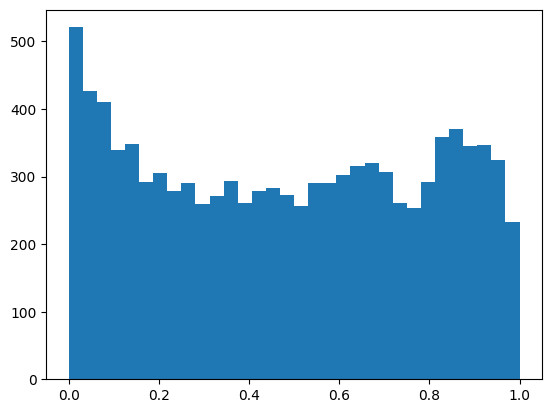

In [15]:
_, ax = plt.subplots()
ax.hist(gmm_pit(*y_mdn_crps, y_test).squeeze(), bins=BINS)

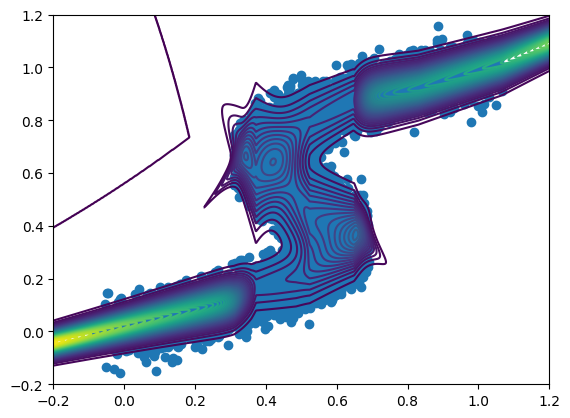

In [16]:
_, ax = plt.subplots()
plot_gmm_density(ax, mdn_crps)
ax.scatter(x_test, y_test)